### Imports

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import plotting_geo

Import data

In [40]:
folder_path_mauro = r'../for_mauro'

wells = np.loadtxt(os.path.join(folder_path_mauro, 'Wells_bentz.txt'))
coulomb_max = np.loadtxt(os.path.join(folder_path_mauro, 'coulomb_max.txt'))
time_series = np.array(pd.read_csv('../data/the_geysers/time_series.csv', header=None))
df_catalogue = pd.read_csv('../data/the_geysers/reduced_catalogue_clustered.csv', index_col=[0])
df_density = pd.read_csv(os.path.join(folder_path_mauro, 'full_results_new_matrix.csv'), index_col=[0])
ics = pd.read_csv(os.path.join(folder_path_mauro, 'ICs.csv'), index_col=[0])
water_injections = pd.read_csv(r"..\data\the_geysers\water_injecion_GLOBAL.csv")



In [3]:
geo_bound = {'lat_min': 38.7,
                'lat_max': 38.9,
                'long_min': -122.95,
                'long_max': -122.65,
                'depth_min': 0,
                'depth_max': 14,
                'step_l': 0.025,
                'step_d': 0.25}

### Clustering check (zero_eq nodes)

In [4]:
for c in unique_labels:
    print(f'Cluster {c}: {np.sum(cluster_labels == c)} nodes, {np.sum(time_series[cluster_labels == c])} events, {np.average(time_series[cluster_labels == c])} on average')

Cluster 1: 203 nodes, 2554.0 events, 0.09985143482680428 on average
Cluster 2: 2304 nodes, 204.0 events, 0.0007027116402116402 on average
Cluster 3: 2233 nodes, 20097.0 events, 0.07142857142857142 on average
Cluster 4: 339 nodes, 94934.0 events, 2.2225499836119305 on average
Cluster 5: 175 nodes, 299608.0 events, 13.58766439909297 on average


In [5]:
for c in unique_labels:
    print(f'Cluster {c}: {np.sum(np.sum(time_series[cluster_labels == c], axis = 1) == 0)} nodes')

Cluster 1: 0 nodes
Cluster 2: 2224 nodes
Cluster 3: 0 nodes
Cluster 4: 0 nodes
Cluster 5: 0 nodes


In [6]:
second_cluster = time_series[cluster_labels == 2]
second_cluster_non_zero = second_cluster[np.sum(second_cluster, axis = 1) != 0]

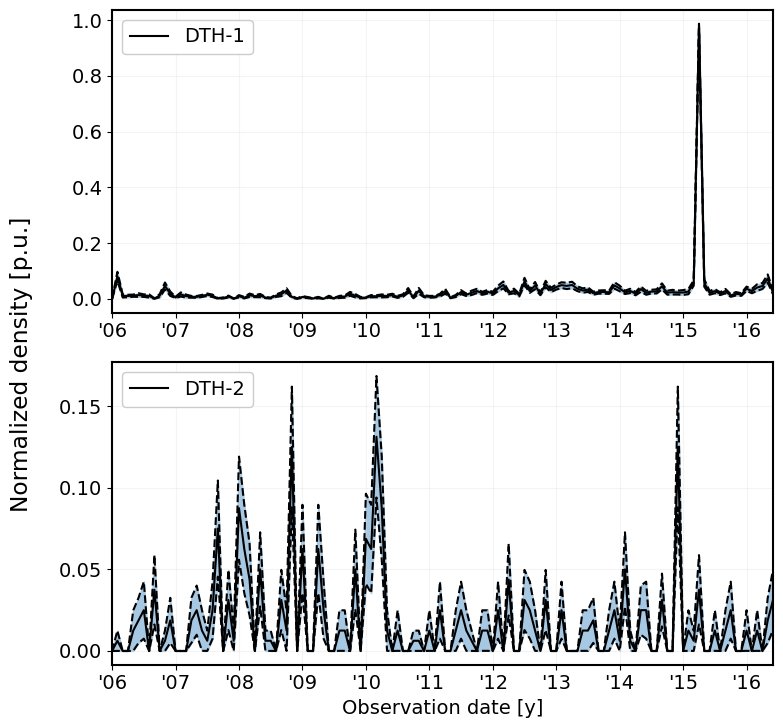

In [7]:
time_series_non_zero = time_series[np.sum(time_series, axis = 1) != 0]
cluster_labels_non_zero = cluster_labels[np.sum(time_series, axis = 1) != 0]
plotting_geo.plot_means_subplots(time_series_non_zero, list(cluster_labels_non_zero), plotted_clusters=[1, 2])

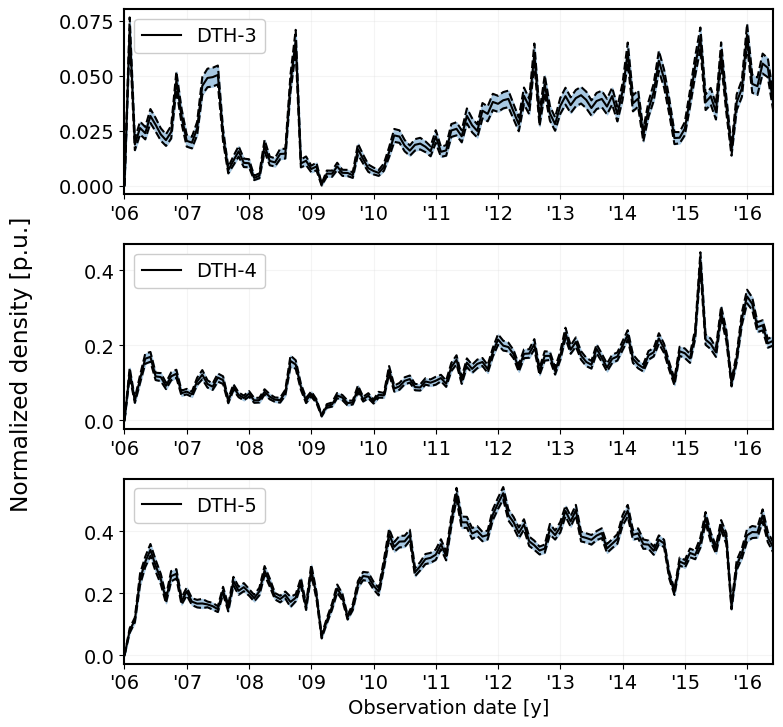

In [8]:
plotting_geo.plot_means_subplots(time_series_non_zero, list(cluster_labels_non_zero), plotted_clusters=[3, 4, 5])

In [41]:
water_injections

,01/01/2006,4.71
0,01/02/2006,10.06
1,01/03/2006,8.71
2,01/04/2006,7.01
3,01/05/2006,6.83
4,01/06/2006,6.44
...,...,...
115,01/09/2015,6.71
116,01/10/2015,8.30
117,01/11/2015,9.52
118,01/12/2015,9.30
